# Commonsense QA

In this notebook we fine-tune BERT to answer common sense multiple-choice questions.
We use the CommonsenseQA dataset from [*CommonsenseQA: A Question Answering Challenge TargetingCommonsense Knowledge*](https://arxiv.org/pdf/1811.00937.pdf)

## Setup Environment

We will use Hugging Face to get a pre-trained BERT model.
We will also use a library called `deeplib`. 

In [1]:
!pip install git+https://github.com/deepditch/deep.lib.git --quiet
!pip install transformers --quiet
!pip install datasets --quiet

     |████████████████████████████████| 5.8 MB 4.6 MB/s 
     |████████████████████████████████| 7.6 MB 59.0 MB/s 
     |████████████████████████████████| 182 kB 72.1 MB/s 
     |████████████████████████████████| 451 kB 4.9 MB/s 
     |████████████████████████████████| 132 kB 74.9 MB/s 
     |████████████████████████████████| 212 kB 75.3 MB/s 
     |████████████████████████████████| 127 kB 79.4 MB/s 


In [2]:
import math
import numpy as np
import datetime

import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import LambdaLR

import transformers
from transformers import AutoModelForMultipleChoice, AutoTokenizer
from transformers.data.data_collator import DataCollator

from datasets import load_dataset

In [3]:
import deeplib
import deeplib.session
import deeplib.schedule
import deeplib.callbacks
import deeplib.validation
from deeplib.LR_Schedule.lr_scheduler import TorchOnBatchLRScheduleCallback

In [4]:
model = "bert-base-uncased"

## Prepare the Dataset

In this section we load the publically availible dataset from Hugging Face's datasets library.
We then prepare each example in the dataset for BERT.


In [5]:
dataset = load_dataset("commonsense_qa") # load the dataset

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/9741 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1221 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1140 [00:00<?, ? examples/s]

Dataset commonsense_qa downloaded and prepared to /root/.cache/huggingface/datasets/commonsense_qa/default/1.0.0/28d68f56649a7f0c23bc68eae850af914aa03f95f810011ae8cf58cc5ff5051b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

To prepare an example for the model, the question is tokenized and concatenated with each multiple choice answer. 
The BERT transformer encodes each question answer pair, and the result is the softmax over all answers.
The full model looks like the following:

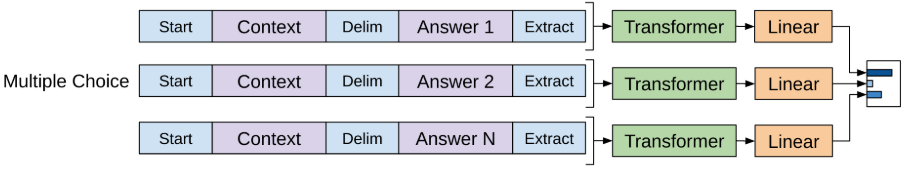


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model)
max_length = 128

def commonsenseqa_features_conversion(example):
    num_choices = len(example["choices"]["text"])

    # Use batch_encode_plus to tokenize the question and concatenate with each answer. 
    # For simplicity each example is padded to the max length of 128.
    # The result is a tensor of shape (N, 128).

    features = tokenizer.batch_encode_plus(list(zip(
            [example["question"]] * num_choices,
            example["choices"]["text"],
        )), max_length=max_length, padding='max_length', truncation=True, return_token_type_ids=True, return_tensors='pt')
    
    labels2id = {char: i for i, char in enumerate("ABCDE")}

    # Dummy answers for test
    if example["answerKey"]:
        features["labels"] = labels2id[example["answerKey"]]
    else:
        features["labels"] = 0    
    return features


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [7]:
# Prepares each question in the corpus for the model.
dataset = dataset.map(commonsenseqa_features_conversion, num_proc=4, batched=False, load_from_cache_file=False)

#0:   0%|          | 0/2436 [00:00<?, ?ex/s]

#1:   0%|          | 0/2435 [00:00<?, ?ex/s]

#2:   0%|          | 0/2435 [00:00<?, ?ex/s]

#3:   0%|          | 0/2435 [00:00<?, ?ex/s]

#1:   0%|          | 0/305 [00:00<?, ?ex/s]

#0:   0%|          | 0/306 [00:00<?, ?ex/s]

#2:   0%|          | 0/305 [00:00<?, ?ex/s]

#3:   0%|          | 0/305 [00:00<?, ?ex/s]

#0:   0%|          | 0/285 [00:00<?, ?ex/s]

#1:   0%|          | 0/285 [00:00<?, ?ex/s]

#2:   0%|          | 0/285 [00:00<?, ?ex/s]

#3:   0%|          | 0/285 [00:00<?, ?ex/s]

To prepare a mini-batch, each example in the mini batch needs to be collated.
Since each example in the dataset is padded to max length, we can simply stack each input into a tensor of shape `(batch_size, N, 128)`.
We also ensure that the `label`, `attention_mask`, and `token_type_ids` tensors are also stacked.

In [8]:
class Collator():
    def __call__(self, features):
        labels_ = torch.tensor([f["labels"] for f in features], dtype=torch.long)
        minibatch_ = {"labels": labels_}

        for k in ['input_ids', 'attention_mask', 'token_type_ids']:
            minibatch_[k] = torch.stack([torch.tensor(f[k]) for f in features])

        return minibatch_, labels_

In [9]:
train_loader = DataLoader(dataset['train'], shuffle=True, batch_size=4, collate_fn=Collator(), num_workers=2)
valid_loader = DataLoader(dataset['validation'], shuffle=True, batch_size=4, collate_fn=Collator(), num_workers=2)

print(train_loader.dataset.data.shape)
print(valid_loader.dataset.data.shape)

(9741, 9)
(1221, 9)


## Train

In this section we fine-tune BERT using the `deeplib` library.
Deeplib has some useful training and logging boilerplate.

In [20]:
model = AutoModelForMultipleChoice.from_pretrained(model, return_dict=True) # Load the pre-trained model

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

In [11]:
import matplotlib.pyplot as plt
accuracy = []
losses = []

#training loop
#train_losses.append(loss_train.item())

#testing
#val_losses.append(loss_val.item())

In [12]:
# This class is used to keep track of accuracy when training. 

class MultipleChoiceAccuracy(deeplib.validation._AccuracyMeter):
    def reset(self):         
        self.num_correct = 0
        self.count = 0

    def update(self, outputs, labels):
        """ During training, the outputs and labels for each mini-batch are passed to this function. """
        preds = outputs.logits.argmax(-1)
        #print(str(outputs) + " " + str(labels))
        self.num_correct += (labels == preds).sum()
        self.count += labels.shape[0]
        
    def metric(self): 
        accuracy.append(self.num_correct / self.count)
        return self.num_correct / self.count


In [13]:
# We apply a weight decay of 0.01 to each non-layer norm or bias parameters.

def make_optimizer(*args, **kwargs):
    no_decay = ["bias", "LayerNorm.weight"]

    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": 0.01,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]

    optimizer = torch.optim.AdamW(
        optimizer_grouped_parameters,
        lr=5e-5
    )

    return optimizer

In [14]:
num_epochs = 1

In [15]:
# For the first 500 iterations of training, we linearly increase the learning rate from 0 to 5e-5.
# For the remaining iterations we linearly decrease to 0.

num_training_steps = len(train_loader) * num_epochs
num_warmup_steps = 500

def lr_lambda(current_step):
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    return max(0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps)))

lr_schedule = TorchOnBatchLRScheduleCallback(LambdaLR, lr_lambda, -1)

In [21]:
def LossWrapper(outputs, label): 
    """ Simple loss wrapper.
    BERT computes loss internally. 
    Deeplib expects a loss function that takes outputs and labels as inputs. """
    losses.append(outputs.loss.detach().cpu().numpy())

    return outputs.loss

training_callbacks = [deeplib.callbacks.GradientClipper(max_grad_norm=1),
                      deeplib.callbacks.TrainingLossLogger(),
                      deeplib.callbacks.TrainingAccuracyLogger(MultipleChoiceAccuracy()),
                      deeplib.validation.Validator(dataloader=valid_loader, accuracy_meter=MultipleChoiceAccuracy()),
                      lr_schedule]

schedule = deeplib.schedule.TrainingSchedule(dataloader=train_loader, num_epochs=num_epochs, callbacks=training_callbacks)
sess = deeplib.session.Session(model=model, criterion=LossWrapper, optim_fn=make_optimizer, lrs=5e-5)

In [ ]:
sess.train(schedule)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2436 [00:00<?, ?it/s]

After 3 epochs, you should reach roughly 50-55% validation accuracy. 

**Next**: [try the notebook for the Conversational Entailment task](https://colab.research.google.com/drive/1QtF8KCEikcy7VcNBPQlV20_P5M6YFdCC?usp=sharing).

In [ ]:
sess.save_model(model)
model_name = sess.load_model(model)
print(model_name)

In [ ]:
!pip install torchinfo

In [ ]:
model.predict(valid_loader)

In [ ]:
print(model)

In [ ]:
from transformers import BertConfig, BertModel
conf = BertConfig.from_pretrained("Trained model", num_labels=2)
model_loaded = AutoModelForMultipleChoice.from_pretrained("Trained model", config=conf)

In [ ]:
"""list = [1,2,3]
#sim = torch.tensor(list[1.2,2.4,3.8,6.1])
tensors = torch.tensor(list)
print(losses[0])

print(losses[0].detach().cpu().numpy())
print(tensors)"""
"""losses2 = []
for i in range(len(losses)):
  if type(losses[i]) == torch.Tensor:
    losses2.append((losses[i].detach().cpu().numpy().item()))
    #break
  else:
    #print(type(losses[i]))
    losses2.append(losses[i].item())
    #break
print(len(losses2))
"""
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
#plt.plot(losses2,label="val")
plt.plot(accuracy,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()